In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load the COVID-19 dataset
data = pd.read_csv("/kaggle/input/corona-virus-report/covid_19_clean_complete.csv")

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Convert date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Check for outliers and inconsistencies
# ... (Use statistical methods or visualization techniques)

# Feature engineering
data['Daily_Cases'] = data['Confirmed'].diff()
data['Mortality_Rate'] = data['Deaths'] / data['Confirmed']

/tmp/ipykernel_17/4061949898.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


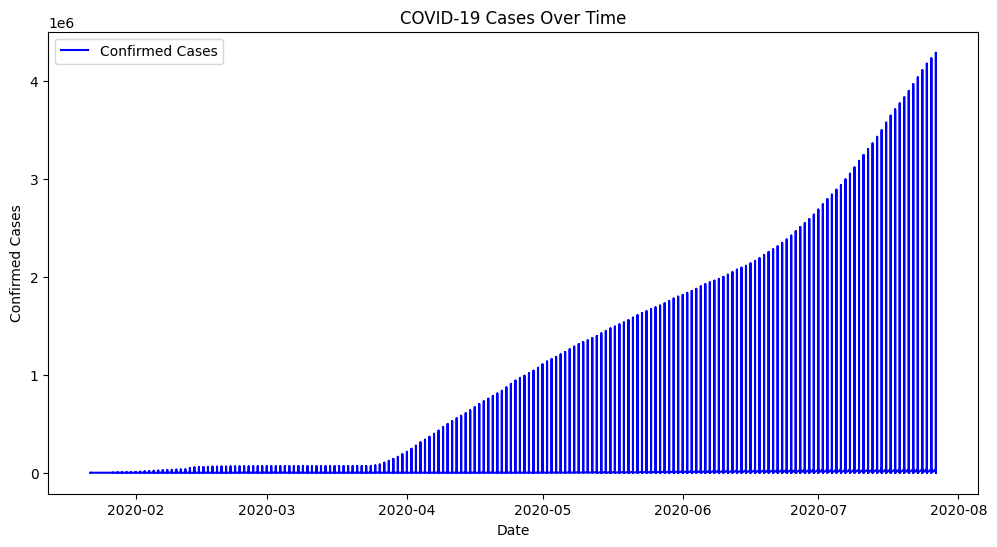

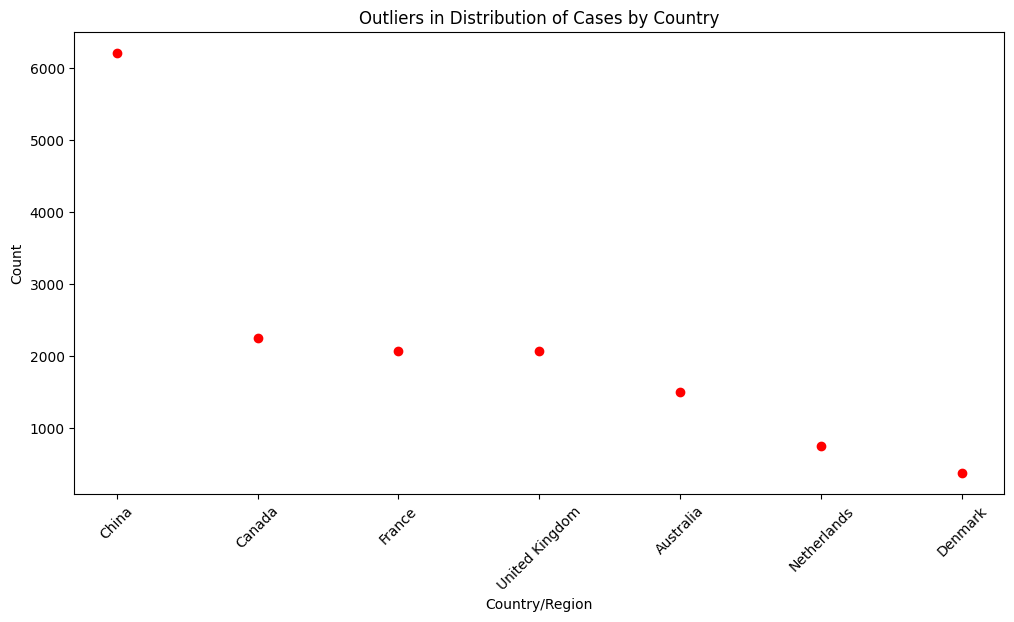

Correlation Matrix Dimensions: (6, 6)


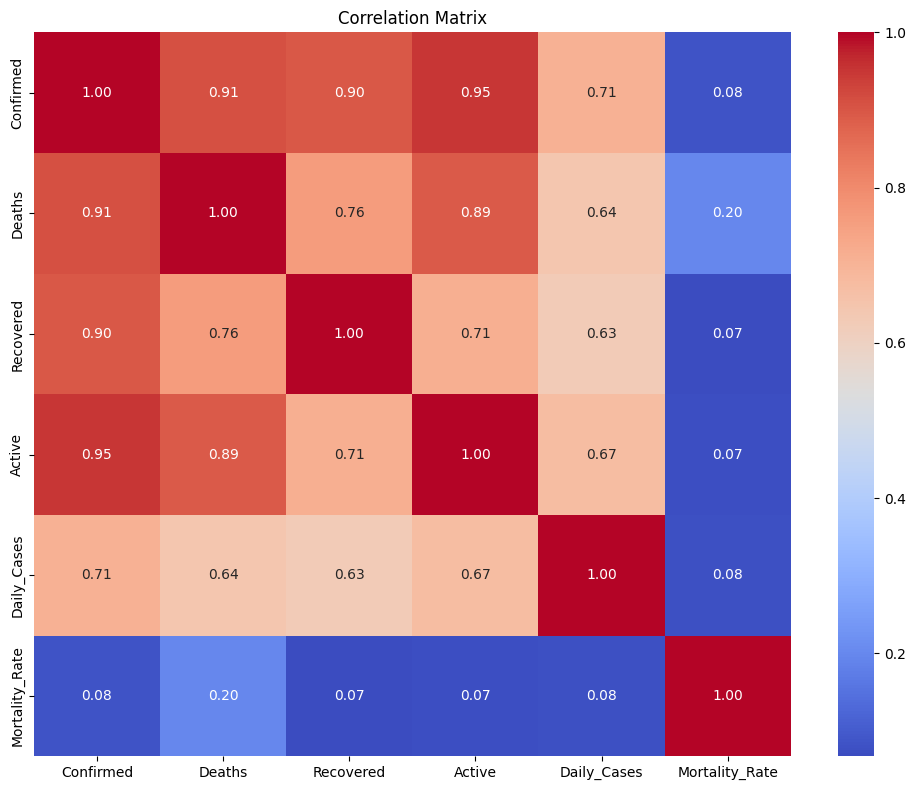

In [2]:
# Time series plot of confirmed cases
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Confirmed'], label='Confirmed Cases', color='blue')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('COVID-19 Cases Over Time')
plt.legend()
plt.show()

# Calculate the count of cases by country
country_counts = data['Country/Region'].value_counts().reset_index()
country_counts.columns = ['Country/Region', 'Count']

# Calculate IQR to find outliers
Q1 = country_counts['Count'].quantile(0.25)
Q3 = country_counts['Count'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = country_counts[
    (country_counts['Count'] < (Q1 - 1.5 * IQR)) | 
    (country_counts['Count'] > (Q3 + 1.5 * IQR))
]

# Plot only outliers using matplotlib
plt.figure(figsize=(12, 6))
plt.scatter(outliers['Country/Region'], outliers['Count'], color='red')
plt.xticks(rotation=45)
plt.xlabel('Country/Region')
plt.ylabel('Count')
plt.title('Outliers in Distribution of Cases by Country')
plt.show()

# Exclude 'Long' and 'Lat' columns (assuming these columns exist)
if 'Long' in data.columns and 'Lat' in data.columns:
    filtered_data = data.drop(columns=['Long', 'Lat'])
else:
    filtered_data = data.copy()

# Reduce to numeric columns only
numeric_data = filtered_data.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numeric_data.corr()

# Check matrix dimensions
print(f"Correlation Matrix Dimensions: {corr_matrix.shape}")

# Limit columns if the matrix is too large
if corr_matrix.shape[0] > 20:  # Arbitrary threshold to limit size
    corr_matrix = corr_matrix.iloc[:20, :20]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()  # Prevent overlapping
plt.show()


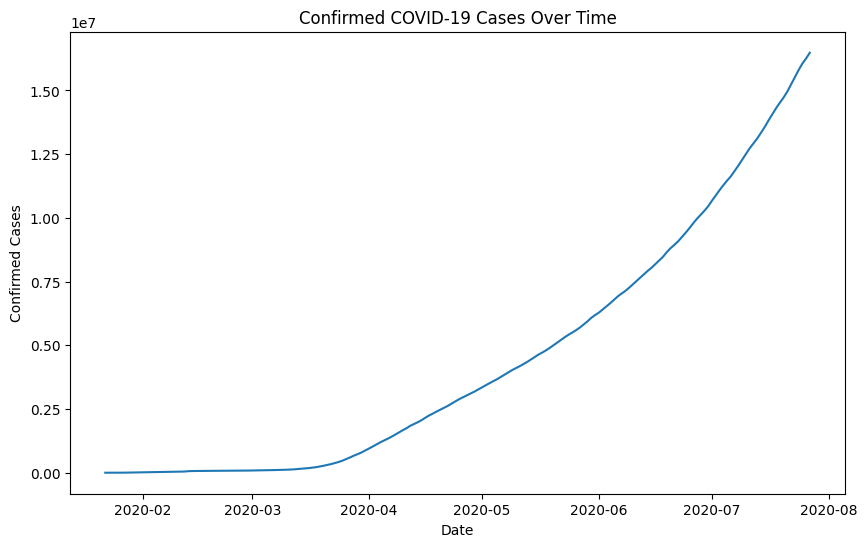

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                  150
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1554.830
Date:                Mon, 09 Dec 2024   AIC                           3121.661
Time:                        19:49:31   BIC                           3139.685
Sample:                    01-22-2020   HQIC                          3128.984
                         - 06-19-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8361      0.067     12.551      0.000       0.706       0.967
ar.L2         -0.0823      0.097     -0.846      0.397      -0.273       0.108
ar.L3          0.1326      0.094      1.416      0.1

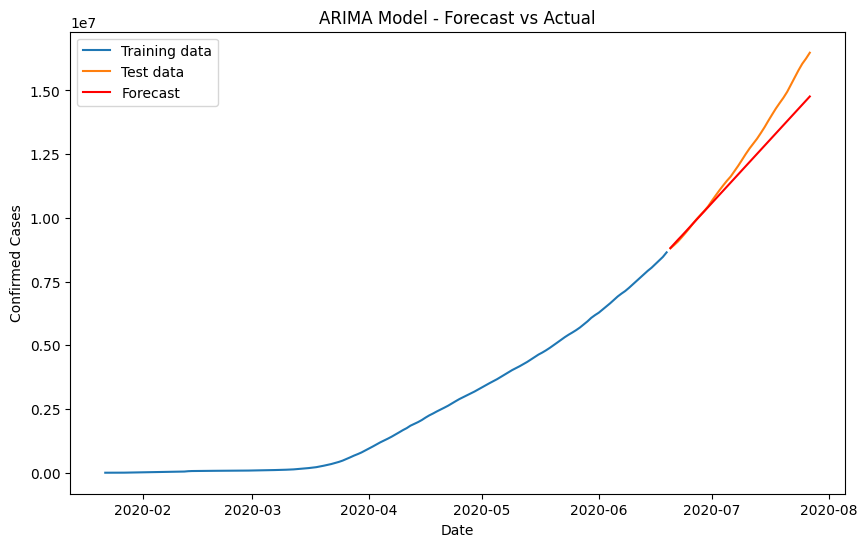

Root Mean Squared Error (RMSE): 773526.0993855227


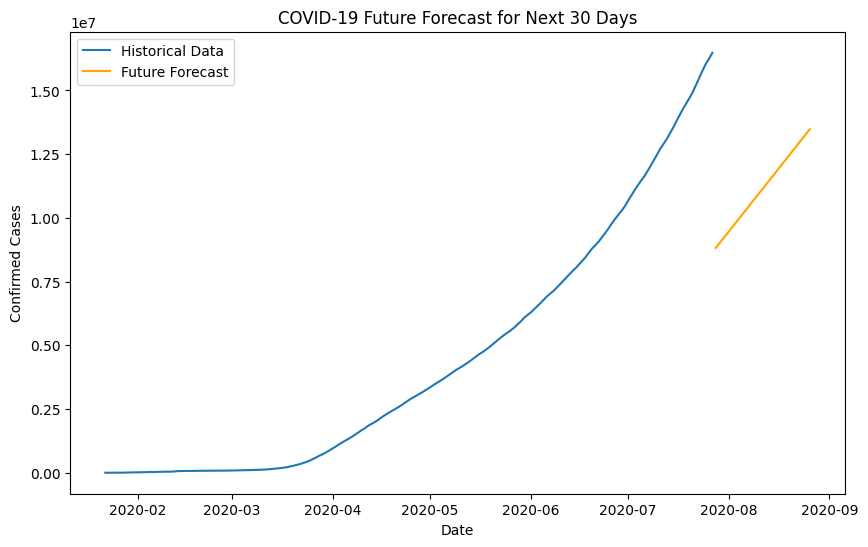

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from datetime import datetime

data1 = pd.read_csv('/kaggle/input/corona-virus-report/day_wise.csv')

# Parse 'Date' as datetime
data1['Date'] = pd.to_datetime(data1['Date'], format='%Y-%m-%d')

# Set 'Date' as the index
data1.set_index('Date', inplace=True)

# Use 'Confirmed' cases as the target variable
confirmed_cases = data1['Confirmed']

# Visualizing the Confirmed cases over time
plt.figure(figsize=(10, 6))
plt.plot(confirmed_cases)
plt.title('Confirmed COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.show()

# Split data into training and testing (80-20 split)
train_size = int(len(confirmed_cases) * 0.8)
train, test = confirmed_cases[:train_size], confirmed_cases[train_size:]

# Build the ARIMA model on the training set
# You may need to tune the (p, d, q) parameters to get the best results
model = ARIMA(train, order=(5, 1, 0))  # p=5, d=1, q=0 are common initial guesses
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast on the test set
forecast = model_fit.forecast(steps=len(test))

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training data')
plt.plot(test.index, test, label='Test data')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Model - Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

# Evaluate model using RMSE
error = rmse(test, forecast)
print(f'Root Mean Squared Error (RMSE): {error}')

# Future Forecast (next 30 days)
future_steps = 30
future_forecast = model_fit.forecast(steps=future_steps)

# Plot future forecast
future_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
plt.figure(figsize=(10, 6))
plt.plot(confirmed_cases, label='Historical Data')
plt.plot(future_dates, future_forecast, label='Future Forecast', color='orange')
plt.title('COVID-19 Future Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()
